In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [2]:
original = pd.read_csv("../../data/processed/BankChurners_more.csv")
campaign_df = pd.read_csv("../../data/processed/Campaign.csv")
segment_result = pd.read_csv("../../data/processed/segmentation_result_static.csv")

# Extracting useful columns to avoid repetition
bank_df = pd.read_csv("../../data/processed/banking_behaviour_preference.csv")
features_from_bank = ['CLIENTNUM','Credit Score',
       'Outstanding Loans', 'Balance','PhoneService','InternetService','TechSupport','PaperlessBilling','PaymentMethod']
bank_df = bank_df.loc[:,features_from_bank]

## 2. What are the key factors influencing customer engagement with our marketing campaigns?
### Analyze historical campaign data to identify main drivers of engagement.

In [4]:
# merging final_df and original
# common columnns:
original = original.merge(bank_df, on = 'CLIENTNUM', how = 'inner')
original = original.merge(campaign_df, on = 'CLIENTNUM', how = 'inner')
original = original.merge(segment_result, on = 'CLIENTNUM', how = 'inner')
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110124 entries, 0 to 110123
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CLIENTNUM               110124 non-null  int64  
 1   Attrition_Flag          110124 non-null  int64  
 2   Customer_Age            110124 non-null  int64  
 3   Gender                  110124 non-null  int64  
 4   Dependent_count         110124 non-null  int64  
 5   Education_Level         110124 non-null  object 
 6   Marital_Status          110124 non-null  int64  
 7   Income_Category         110124 non-null  int64  
 8   Card_Category           110124 non-null  int64  
 9   Month_with_bank         110124 non-null  int64  
 10  No_of_product           110124 non-null  int64  
 11  Months_Inactive_12_mon  110124 non-null  int64  
 12  Credit_Limit            110124 non-null  float64
 13  Total_Revolving_Bal     110124 non-null  int64  
 14  Total_Trans_Amt     

In [5]:
outcome_counts = original['Outcome'].value_counts(normalize = True) * 100

success_percentage = outcome_counts.get(1, 0)
failure_percentage = outcome_counts.get(0, 0)

# Display the percentages
print(f"Success Rate: {success_percentage:.2f}%")
print(f"Failure Rate: {failure_percentage:.2f}%")

Success Rate: 50.18%
Failure Rate: 49.82%


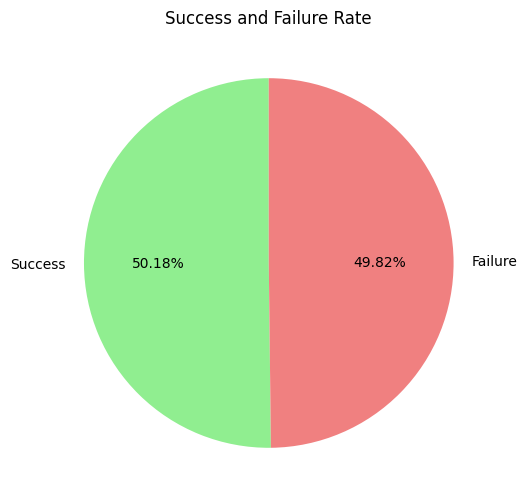

In [6]:
# pie chart
labels = ['Success', 'Failure']
percentages = [success_percentage, failure_percentage]
plt.figure(figsize = (6, 6))
plt.pie(percentages, labels = labels, autopct = '%1.2f%%', colors = ['lightgreen', 'lightcoral'], startangle=90)
plt.title('Success and Failure Rate')
plt.show()

In [7]:
ori = original.copy()
cols_to_std = ['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']
ori[cols_to_std] = (ori[cols_to_std] - ori[cols_to_std].mean()) / ori[cols_to_std].std()
ori[['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']].corr()

,Duration_of_Contact,Num_of_Contacts_Made,Outcome
Duration_of_Contact,1.000000,0.000818,0.003610
Num_of_Contacts_Made,0.000818,1.000000,-0.001875
Outcome,0.003610,-0.001875,1.000000


The correlation matrix does not show high correlation between `Outcome` and any other variable. The highest positive correlation is between `Outcome` and `Duration_of_Contacts`.

In the next part, Random Forest Classifier will be used to find the most important features.

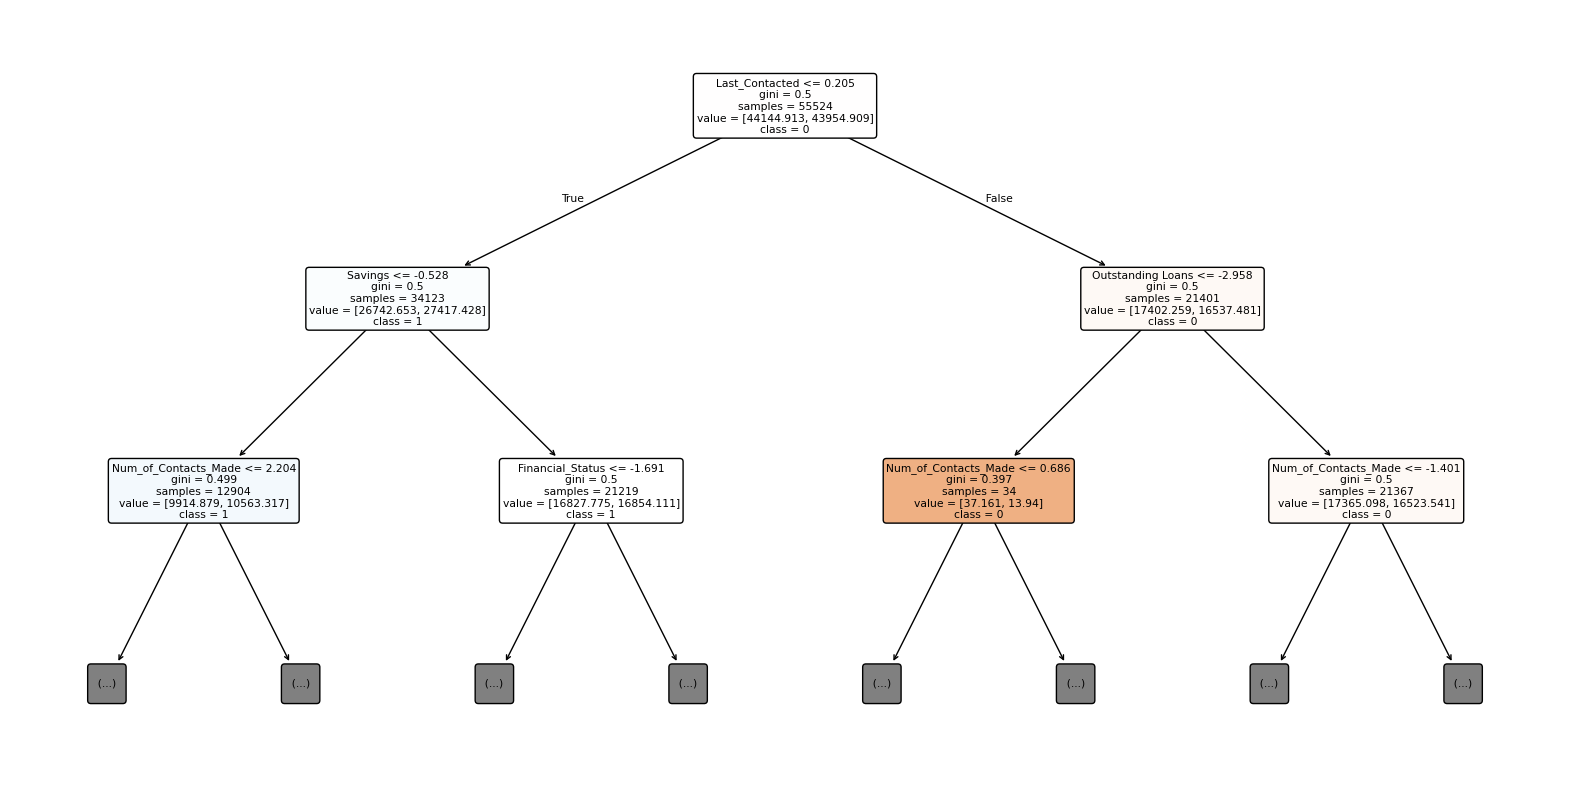

In [8]:
# drop the unncessary columns
X = ori.drop(columns=['CLIENTNUM', 'Attrition_Flag', 'Outcome']).copy()
# one-hot encode the categorical columns
X = pd.get_dummies(X, drop_first=True)

y = original['Outcome']
y = (original['Outcome'] >= 1).astype(int)  # Converts Outcome to 0 or 1

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# the tree
tree = rf_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X.columns), class_names=['0', '1'], filled=True, rounded=True, max_depth=2)
plt.show()

The tree shows the first few decisions made by the model when clasifying the `Outcome` to be yes or no. This tree is just a subset of the entire tree, with a depth of 2 levels only. I did not include it since the actual tree is much larger.

This tree will be helpful in finding the features that contribute the most to the outcome. The top importance of the features will be ranked next.

In [289]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Balance,0.059081
Outstanding Loans,0.059071
Credit Score,0.058972
Duration_of_Contact,0.058589
Total_Trans_Amt,0.057611
Last_Contacted,0.056997
Credit_Limit,0.056710
Savings,0.051539
Avg_Utilization_Ratio,0.050401
Total_Revolving_Bal,0.049979


Since there are so many features, we will get the top 5.

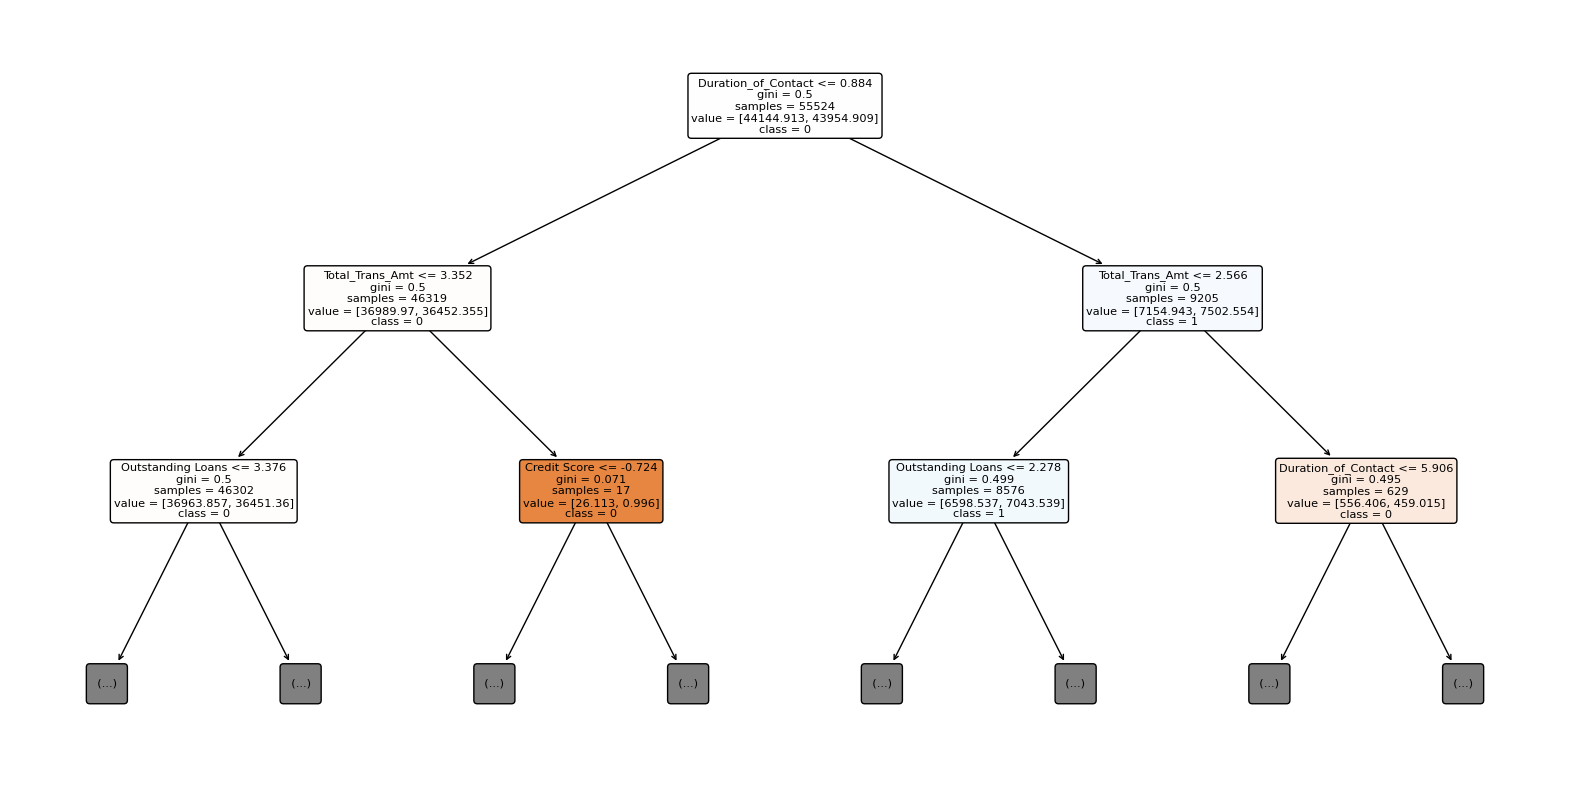

In [301]:
# Get the top 5 most important features
top_5_impt = impt.head(5)
top_5_features = top_5_impt.index.tolist()
X = X[top_5_features]

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# the tree
tree = rf_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X.columns), class_names=['0', '1'], filled=True, rounded=True, max_depth=2)
plt.show()

This tree is also a subset of the original much larger tree.

In [303]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Balance,0.203188
Outstanding Loans,0.203143
Credit Score,0.202589
Total_Trans_Amt,0.199716
Duration_of_Contact,0.191364


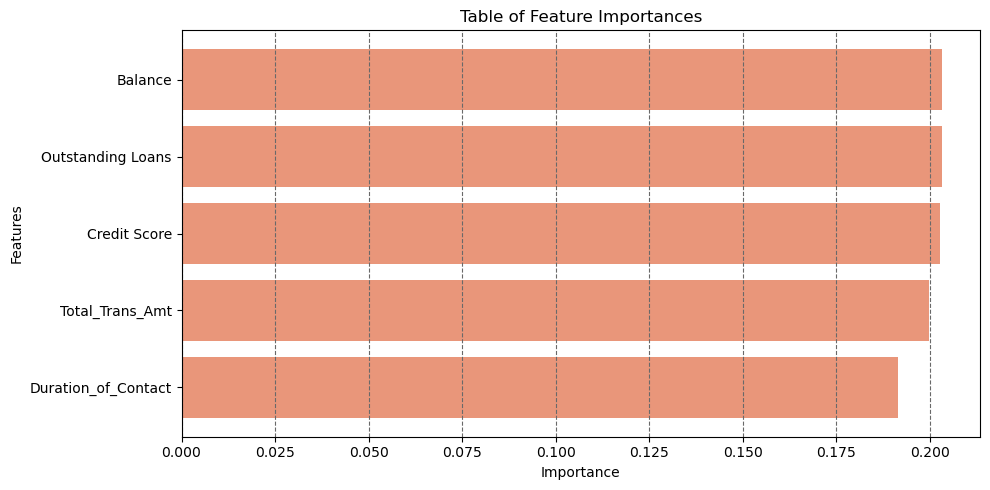

In [304]:
# Plotting the feature importances
plt.figure(figsize = (10, 5))
plt.title("Table of Feature Importances")
plt.grid(axis = 'x', linestyle = '--', alpha = 1, color = 'dimgray')
plt.barh(impt.index, impt["Importance"], align = "center", color = 'darksalmon')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

`Balance` is the most important feature. This is followed by, `Outstanding Loans`, `Credit Score`, `Total_Trans_Amt` and `Duration_of_Contact`.

#### Analysis
- `Balance` and `Outstanding Loans`: These 2 variables indicate that customers who have higher balances and existing loan obligations are more likely to respond positively to the campaign.  This is logical, as these individuals are more embedded in the bank’s ecosystem, suggesting they have a greater level of trust and an ongoing relationship with the institution.
- `Credit Score`: A higher credit score generally reflects financial stability, which may lead to an increased willingness to accept offers from the bank. These customers are also less risky to offer more premium campaigns to.
- `Total_Trans_Amt`: This feature indicates the total amount spent by the customer through bank services. Higher transaction amounts often suggest more frequent use of the bank’s services, suggesting a deeper connection and a higher chance of the customer accepting a new product or service.
- `Duration_of_Contact`: The length of time spent on the call between the customer and the call center agent also plays a significant role. Longer call durations may suggest that the customer is more engaged or interested, making them more receptive to the campaign.

The analysis of these top features suggests that the most effective customers to target for the campaign are those with an established relationship with the bank, including frequent transactions, loans, and a good credit score. Additionally, call center agents play a critical role in persuading these customers. Ensuring that agents are well-trained to engage customers for longer periods and provide convincing information is key to improving campaign success.

Thus, it would be beneficial to focus marketing efforts on customers who already have a robust and ongoing relationship with the bank and equip call agents with strategies to maintain longer more engaging conversations.

### Propose metrics for tracking campaign effectiveness over time

##### Key Factors Influencing Customer Engagement
1) Customer Segmentation:
    1. **Low Financial status, Low Loyalty** = 1
  
    2. **Moderate or low Financial status, Moderate or low Loyalty** = 2

    3. **Low or Moderate Financial status, High Loyalty** = 3

    4. **High Financial status, Low or Moderate Loyalty** = 4
   
    5. **High Financial status, High Loyalty** = 5

2) Personalization:
    - Personalization is crucial across all segments. The more tailored a campaign is to a customer’s habits, needs, and preferences, the higher the likelihood of engagement. For instance, using customer data to send offers relevant to their transaction behavior, product usage, or financial status can greatly increase engagement.

3) Communication Channel:
    - Digital capability levels directly influence the preferred channels for communication. Highly digitally engaged customers are more responsive to email, social media, or app notifications, while others may prefer direct mail or phone calls. 


##### Proposed Metrics for Tracking Campaign Effectiveness
1) Engagement Rate:
    - Tracks the overall interaction with campaigns (e.g., email opens, clicks). This is a key indicator of initial interest across all customer segments.
2) Conversion Rate:
    - Measures the percentage of customers who complete the desired action (e.g., purchase, sign-up), giving direct insight into campaign success.
3) Customer Lifetime Value (CLV):
    - Helps track long-term profitability and how successful campaigns are in retaining and increasing the value of customers over time.
4) Return on Marketing Investment (ROMI):
    - Shows the financial impact of campaigns by comparing revenue generated to campaign costs, ensuring resources are allocated efficiently.

In [10]:
# 1) Engagement Rate Calculation
def calculate_engagement_rate(df):
    """
    Calculate the engagement rate by dividing the total engagements by the total number of campaigns.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Digital_Capability' column, 
                    representing customer interactions or engagements with digital campaigns.

    Returns:
    float: The engagement rate, calculated as total engagements / total campaigns.
           Returns 0 if there are no campaigns.
    """
    total_engagements = df['Digital_Capability'].sum()  
    total_campaigns = len(df)  
    return total_engagements / total_campaigns if total_campaigns > 0 else 0

# 2) Conversion Rate Calculation
def calculate_conversion_rate(df):
    """
    Calculate the conversion rate by dividing the total number of conversions by the total number of customers.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Outcome' column, 
                    where 'Converted' indicates a successful conversion.

    Returns:
    float: The conversion rate, calculated as total conversions / total customers.
           Returns 0 if there are no customers.
    """
    total_conversions = df[df['Outcome'] == 'Converted'].shape[0] 
    total_customers = len(df)
    return total_conversions / total_customers if total_customers > 0 else 0

# 3) Customer Lifetime Value (CLV) Calculation
def calculate_clv(df):
    """
    Estimate Customer Lifetime Value (CLV) based on the average 'Balance' for each customer.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Balance' column.

    Returns:
    float: The average CLV across customers, calculated as the mean balance.
           Returns 0 if 'Balance' column is not present in the dataset.
    """
    return df['Balance'].mean() if 'Balance' in df.columns else 0

# 4) Return on Marketing Investment (ROMI) Calculation
def calculate_romi(df):
    """
    Calculate the Return on Marketing Investment (ROMI) by dividing the net profit 
    (total revenue - total cost) by the total cost.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Total_Trans_Amt' column, 
                    representing revenue, and 'Savings' column, representing marketing costs.

    Returns:
    float: The ROMI, calculated as (total revenue - total cost) / total cost.
           Returns 0 if there are no marketing costs.
    """
    total_revenue = df['Total_Trans_Amt'].sum()  
    total_cost = df['Savings'].sum() 
    return (total_revenue - total_cost) / total_cost if total_cost > 0 else 0

# Calculate the metrics
engagement_rate = calculate_engagement_rate(ori)
conversion_rate = calculate_conversion_rate(ori)
clv = calculate_clv(ori)
romi = calculate_romi(ori)

print(f"Engagement Rate: {engagement_rate:.2f}")
print(f"Conversion Rate: {conversion_rate:.2f}")
print(f"Customer Lifetime Value (CLV): {clv:.2f}")
print(f"Return on Marketing Investment (ROMI): {romi:.2f}")


Engagement Rate: 0.88
Conversion Rate: 0.00
Customer Lifetime Value (CLV): 124267.90
Return on Marketing Investment (ROMI): -0.98


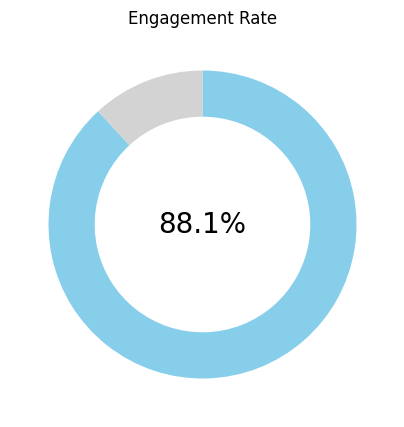

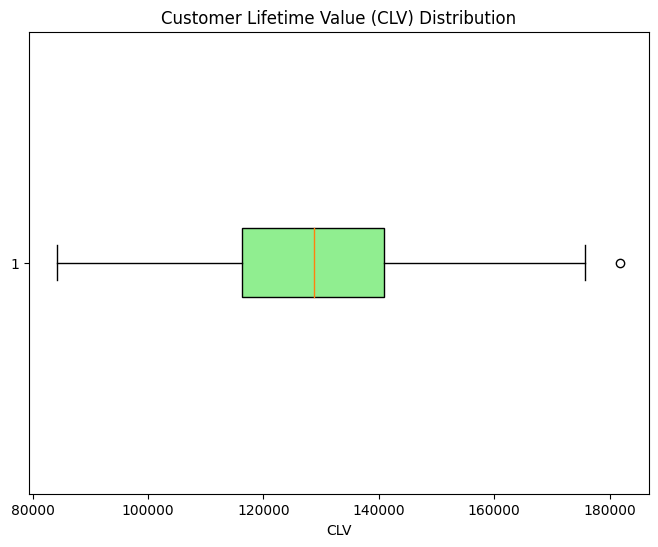

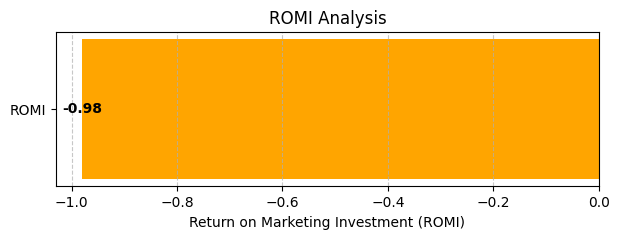

In [22]:
# Gauge Chart for Engagement Rate
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie([engagement_rate, 1 - engagement_rate], startangle=90, counterclock=False, 
       colors=['skyblue', 'lightgrey'], wedgeprops=dict(width=0.3))
ax.text(0, 0, f"{engagement_rate*100:.1f}%", ha='center', va='center', fontsize=20)
plt.title('Engagement Rate')
plt.show()

# Box Plot for  CLV
clv_data = np.random.normal(clv, 20000, 100)  # Simulate CLV data based on the updated CLV mean
plt.figure(figsize=(8, 6))
plt.boxplot(clv_data, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Customer Lifetime Value (CLV) Distribution')
plt.xlabel('CLV')
plt.show()

# Horizontal bar chart for ROMI
romi_value = -0.98  # Current ROMI value
romi_category = ['ROMI']
plt.figure(figsize=(7, 2))
plt.barh(romi_category, romi_value, color='orange')
plt.xlabel("Return on Marketing Investment (ROMI)")
plt.title("ROMI Analysis")
for index, value in enumerate([romi_value]):
    plt.text(value, index, f'{value:.2f}', ha='center', va='center', color="black", fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [11]:
original.to_csv('../../data/processed/Compaign_metrics.csv', index=False)